# Exercise 1, Mini Image Classifier (Colab Version), 28P(oints)

## Lab Instructions
All your answers of this exercise should be written **in this notebook**.
You shouldn't need to write or modify any other files.

**You should execute every block of code to not miss any dependency. For the
training tasks, your notebook should contain the classification accuracy (the
 figures are NOT necessary however).
 Please DO NOT clear the notebook output when you submit it.
 Please DO NOT upload the dataset when you submit your homework.**

This exercise was developed by Ge Li for the KIT Cognitive Systems Lecture,
July 2021.

## Task instructions:
In this jupyter notebook, you are going to define multiple **Image
classifiers** with different structures. Read the instruction and example code
carefully and finish the tasks. You can run the training procedure and
thereby verify your computation and implementation.<br>

Detailed instructions:

0. You need to connect colab to your google drive in order to download the CIFAR-10 data set. Colab provides a GPU by clicking "Runtime" -> "Change runtime type" and then selecting GPU as a hardware accelerator.<br><br>

1. The dataset you are working with is CIFAR-10. The code in the cell of the **data_loader** will download and manage this dataset for you. You do not
 need to write any code for it.<br><br>

2. The deep learning platform you are working with is PyTorch. In the scope of
this homework, you can learn the fundamental knowledge from the instructions.
 You don't have to spend much time on external materials / tutorials.<br><br>

3. In this notebook, you will focus on the Neural Network models for image
classification. A classifier with fully connected layers is given as an
example. This example mainly contains two parts: a **constructor** in which
all the layers to be used are initialized (except activation function), and a
**forward** function, where the forward pass process of the network is defined. In PyTorch, once the forward function of a network is given, the gradient of the loss function with respect to the network parameters can be automatically computed and back-propagated.<br><br>

4. In your model's constructor, you may need to call these functions:
    - Define fully connected layers: **nn.Linear(in_features, out_features)**,
such as: nn.Linear(64, 10)
    - Define 2-D convolutional layers: **nn.Conv2d(in_channels, out_channels,
kernel_size, stride, padding)**, such as: nn.Conv2d(8, 16, 5, padding=0)
    - Define max-pooling layers: **nn.MaxPool2d(kernel_size, stride)**, such as:
nn.MaxPool2d(2, 2)<br><br>

5. In your model's forward function, you may need to call these functions:
    - Flatten the 3rd order tensor to 1st order tensor: e.g. **x = torch
    .flatten(x, 1)**
    - Relu activation function: e.g. **x = F.relu(x)**<br><br>

6. All the training and plotting related code are offered by the **fit** function. The contents can be described in the pseudo code below, which is also a common workflow in deep learning. <br>
    - Get train, valid and test data-loader to load data from dataset.
    - Initialize the loss function and optimizer for parameters' updating.
    - Loop in epochs:
        - Loop in batch of training dataset:
            - Compute the output using forward function
            - Compute the loss using output and labels
            - Applying back-propagation and update network parameters
            - Record the training loss
        - Loop in batch of validation dataset:
            - Compute the output using forward function
            - Compute the loss using output and labels
            - Record the validation loss
        - Plotting the training and validation loss for each epoch.
        - save model's parameters if the model achieves a better performance
        - break the loop (early stopping) if the validation loss keeps
        increasing.
    - Apply the model with the best parameters to the test dataset and get the
    result (classification accuracy).
<br><br>

In [1]:
# Your work will be stored in a folder called `cogsys_ss22_hw6` by default to prevent Colab
# instance timeouts from deleting your edits.
# We do this by mounting your google drive on the virtual machine created in this colab
# session. For this, you will likely need to sign in to your Google account and copy a
# passcode into a field below

import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Create paths in your google drive

DRIVE_PATH = '/content/gdrive/My\ Drive/cogsys_ss22_hw6'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

# the space in `My Drive` causes some issues,
# make a symlink to avoid this
SYM_PATH = '/content/cogsys_ss21'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/cogsys_ss22_hw6


Run the next cell once to download the dataset

In [3]:
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK

import torch
import torchvision
import torchvision.transforms as transforms

# Fix random seed to make sure the result in your computer is reproducible
torch.manual_seed(0)


def get_data_loader():
    # Define a composed transform of pre-processing the dataset
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                         (0.5, 0.5, 0.5))])

    # Load CIFAR-10 dataset
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
    train_set, valid_set = torch.utils.data.random_split(train_set, [40000,
                                                                     10000])

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

    # Construct data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=512,
                                               shuffle=True, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(test_set, batch_size=1024,
                                               shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=512,
                                              shuffle=False, num_workers=2)

    return train_loader, valid_loader, test_loader

# Get data loaders
# data loader is an object used as as an iterator, which can be use in the
# for... in loop, such as:
#
#             for data in dataloader:
#                 blablabla...

train_loader, valid_loader, test_loader = get_data_loader()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK


# Import Python libs
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange


def fit(model, max_epochs, device, early_stop=True):
    """
    Train model, store the best model, and run a final test.
    :param model: NN model used in the image classification
    :param max_epochs: the iteration number for using all data in train_dataset
    :param early_stop: stop the training if the loss in valid_dataset
    keeps increases
    :return: None
    """

    # Use cross entropy as the loss function in classification
    loss_func = nn.CrossEntropyLoss()

    # Define an optimizer for gradient descent
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize a dict to store the best model during training
    best_model_dict = model.state_dict()

    # Define a iterator object to print progress bar
    epochs = trange(max_epochs, desc=model.__class__.__name__ + ' Training',
                    unit='Epoch', dynamic_ncols=True)

    # Record the training and validation loss
    train_loss_list = []
    valid_loss_list = []

    # Initialize a figure to show loss functions
    plt.figure()

    # Main loop. Each iteration will use all the data in training dataset,
    # called as epoch.
    for epoch in epochs:
        # Unfreeze the parameters in the NN model
        model.train()
        train_batch_num = 0
        train_loss = 0.0
        # each batch, a group of data in the dataset form a batch.
        for inputs, labels in train_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients. Every time after do gradient
            # back-propagation, the gradient will remain in the model,
            # we need to clean it before update again.
            optimizer.zero_grad()

            # compute outputs, here your "forward" function in the model will
            # be called by PyTorch automatically.
            outputs = model(inputs)

            # Compute loss, here the loss is averaged to the batch.
            loss = loss_func(outputs, labels)

            # loss back propagation
            loss.backward()

            # The parameters in the model get updated
            optimizer.step()

            # get some statistics
            train_loss += loss.item()
            train_batch_num += 1

        # save train loss of current epoch
        train_loss_list.append(train_loss / train_batch_num)

        # Before we evaluate the data, we need to frozen the parameters in
        # the model
        model.eval()

        # Use validation dataset to evaluate the training result. This can avoid
        # over-fitting
        valid_loss = 0.0
        valid_batch_num = 0

        for inputs, labels in valid_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute loss
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            # get statistics
            valid_loss += loss.item()
            valid_batch_num += 1

        # save validation loss of current epoch
        valid_loss_list.append(valid_loss / valid_batch_num)

        # export the training losses to the progress bar
        epochs.set_postfix(OrderedDict({"train_loss": train_loss_list[-1],
                                        "valid_loss": valid_loss_list[-1]}))

        # Record the best model
        if epoch > 0 and valid_loss_list[-1] == min(valid_loss_list):
            best_model_dict = model.state_dict()

        # Apply early stopping
        if early_stop and epoch > 5 and min(valid_loss_list) not in \
                valid_loss_list[-5:]:
            break

    # Plot result in a figure
    plt.plot(range(1, epoch + 2), train_loss_list, color='b')
    plt.plot(range(1, epoch + 2), valid_loss_list, color='r')
    plt.legend(["Train loss", "valid loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training and validation loss in " + model.__class__.__name__)
    plt.show()
    print("Finished Training.")

    # Training is finished, now get our best model to test
    model.load_state_dict(best_model_dict)

    correct = 0
    total = 0
    with torch.no_grad():
        # We use test dataset for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (
            100 * correct / total))


In [5]:
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK

# Import Python libs
import torch
import torch.nn as nn
import torch.nn.functional as F

# Fix random seed to make sure the result in your computer is reproducible
torch.manual_seed(0)

# Max training epochs
max_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Task a)
- Read the implementation of fully connected layers classifier, then run the
cell afterwards to train this classifier. The training result will be shown
automatically.

In [7]:
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK
# DO NOT MODIFY THIS BLOCK

class FCLayersNet(nn.Module):
    """
    Image classifier using fully connected layers
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(FCLayersNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        """
        This function defines the forward pass of this net model.
        Once this function is defined, the gradient back-propagation can be
        automatically computed by PyTorch.

        :param x: input data of this model
        :return: output data of this model
        """
        # The original data is 3rd order tensor, we need to flatten it to 1st
        # order tensor, as the input of the fully connected layer.
        x = torch.flatten(x, 1)

        # The data pass through the fully connected layers one after another
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)

        return x

- Run next cell and see the training progress and results.

FCLayersNet Training:   8%|▊         | 8/100 [01:31<17:29, 11.41s/Epoch, train_loss=0.858, valid_loss=1.41]


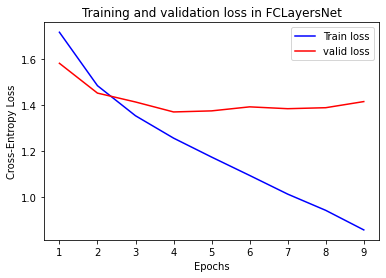

Finished Training.
Accuracy of the network on the 10000 test images: 52.89 %


In [10]:
# Run me
%matplotlib inline
fc_net = FCLayersNet().to(device)
fit(fc_net, max_epochs, device, early_stop=True)

### Task b)

- Write down the missing cells:<br>

    - I: 28*28*8, II: 28*28*8, III: 24*24*16, IV: 24*24*16, V: 20*20*16, VI: 20*20*16

- Finish the implementation:

In [13]:
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK

class ConvLayersNet(nn.Module):
    """
    Image classifier using convolutional layers
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(ConvLayersNet, self).__init__()
        ########   Your code begins here   ########
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 24 * 24, 10)
        ########   Your code ends here   ########

    def forward(self, x):
        """
        This function defines the forward pass of this net model.
        Once this function is defined, the gradient back-propagation can be
        automatically computed by PyTorch.

        :param x: input data of this model
        :return: output data of this model
        """
        ########   Your code begins here   ########
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        # The original data is 3rd order tensor, we need to flatten it to 1st
        # order tensor, as the input of the fully connected layer.
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        ########   Your code ends here   ########
        return x

- Run next cell and see the training progress and results.

ConvLayersNet Training:  15%|█▌        | 15/100 [02:44<15:32, 10.97s/Epoch, train_loss=0.673, valid_loss=1.23]


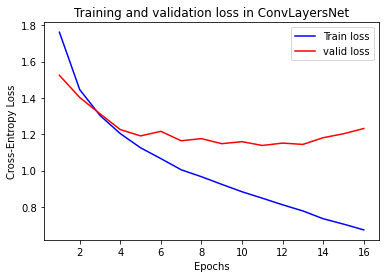

Finished Training.
Accuracy of the network on the 10000 test images: 60.12 %


In [14]:
# Run me
%matplotlib inline
conv_net = ConvLayersNet().to(device)
fit(conv_net, max_epochs, device, early_stop=True)

### Task c)

- Recall the knowledge in Cognitive system lecture, what kind of benefits can
we expect when applying max-pooling layer in CNNs?<br>

- Write down the missing cells:<br>

    - I: 28*28*8, II: 28*28*8, III: 14*14*8, IV: 14*14*8, V: 10*10*16, VI: 10*10*16, VII: 5*5*16, VIII: 5*5*16

- Finish the implementation:

In [15]:
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK

class CNN(nn.Module):
    """
    Image classifier using CNNs with max pooling channels.
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(CNN, self).__init__()
        ########   Your code begins here   ########
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 2 * 2, 10)
        ########   Your code ends here   ########

    def forward(self, x):
        """
        This function defines the forward pass of this net model.
        Once this function is defined, the gradient back-propagation can be
        automatically computed by PyTorch.

        :param x: input data of this model
        :return: output data of this model
        """
        ########   Your code begins here   ########
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        ########   Your code ends here   ########
        return x

- Run next cell and see the training progress and results.

CNN Training:  67%|██████▋   | 67/100 [11:44<05:47, 10.52s/Epoch, train_loss=0.941, valid_loss=1.07]


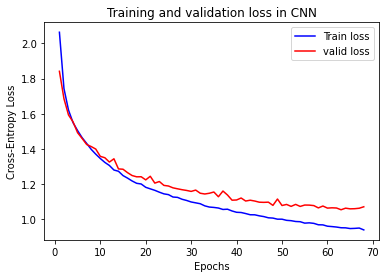

Finished Training.
Accuracy of the network on the 10000 test images: 63.13 %


In [16]:
# Run me
%matplotlib inline
cnn = CNN().to(device)
fit(cnn, max_epochs, device, early_stop=True)

### Task d)

- Write down the missing cells:<br>



    - I: 30*30*8, II: 30*30*8, III: 15*15*8, IV: 15*15*8, V: 13*13*16, VI: 13*13*16, VII: 6*6*16, VIII: 6*6*16

- Finish the implementation:

In [81]:
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK

class MiniResNetSimple(nn.Module):
    """
    Image classifier using ResNets with small channel size.
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(MiniResNetSimple, self).__init__()
        ########   Your code begins here   ########
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.res1_conv1 = nn.Conv2d(8, 8, 3, padding=1)
        self.res1_conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.res2_conv1 = nn.Conv2d(8, 8, 3, padding=1)
        self.res2_conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 14 * 14, 10)
        ########   Your code ends here   ########

    def forward(self, x):
        """
        This function defines the forward pass of this net model.
        Once this function is defined, the gradient back-propagation can be
        automatically computed by PyTorch.

        :param x: input data of this model
        :return: output data of this model
        """
        ########   Your code begins here   ########
        x = self.conv1(x)
        
        x = F.relu(x)
        x = self.max_pool(x)
        
        res = x

        x = self.res1_conv1(x)
        x = F.relu(x)
        
        x = self.res1_conv2(x)
        
        x = F.relu(x + res)
        
        res = x

        x = self.res2_conv1(x)
        x = F.relu(x)
        
        x = self.res2_conv2(x)
        x = F.relu(x + res)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
 
        ########   Your code ends here   ########
        return x


- Run next cell and see the training progress and results.

MiniResNetSimple Training:  46%|████▌     | 46/100 [07:46<09:07, 10.14s/Epoch, train_loss=0.875, valid_loss=1.09]


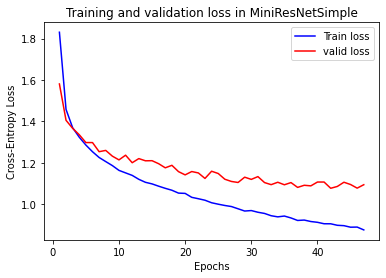

Finished Training.
Accuracy of the network on the 10000 test images: 62.05 %


In [82]:
# Run me
%matplotlib inline
resnet = MiniResNetSimple().to(device)
fit(resnet, max_epochs, device, early_stop=True)

## Task e)

- Write down the missing cells:<br>

In [ ]:
- I: 30*30*8, II: 30*30*8, III: 15*15*8, IV: 15*15*8, V: 13*13*16, VI: 13*13*16, VII: 6*6*16, VIII: 6*6*16

- Finish the implementation:

In [6]:
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK
# TODO: PLEASE FINISH THE IMPLEMENTATION IN THIS BLOCK

class MiniResNet(nn.Module):
    """
    Image classifier using ResNets with increasing channel size.
    """

    def __init__(self):
        """
        Model Constructor, Initialize all the layers to be used
        """
        super(MiniResNet, self).__init__()
        ########   Your code begins here   ########
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool = nn.MaxPool2d(2, 2)

        self.short_cut_2 = nn.Conv2d(8, 16,
                                     kernel_size=1, stride=2)
        self.res1_conv1 = nn.Conv2d(8, 8, 3, stride=1, padding=1)
        self.res1_conv2 = nn.Conv2d(8, 8, 3, padding='same')
        self.res2_conv1 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.res2_conv2 = nn.Conv2d(16, 16, 3, padding='same')
        self.fc1 = nn.Linear(16 * 7 * 7, 10)
        ########   Your code ends here   ########

    def forward(self, x):
        """
        This function defines the forward pass of this net model.
        Once this function is defined, the gradient back-propagation can be
        automatically computed by PyTorch.

        :param x: input data of this model
        :return: output data of this model
        """
        ########   Your code begins here   ########

        x = self.conv1(x)
        x = F.relu(x)

        x = self.max_pool(x)

        res = x # self.short_cut_1(x)

        x = self.res1_conv1(x)
        x = F.relu(x)

        x = self.res1_conv2(x)
        
        x = F.relu(x + res)
        
        res = self.short_cut_2(x)

        x = self.res2_conv1(x)
        x = F.relu(x)
        
        x = self.res2_conv2(x)
        x = F.relu(x + res)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
 
        ########   Your code ends here   ########
        return x


MiniResNet Training:  52%|█████▏    | 52/100 [09:10<08:28, 10.59s/Epoch, train_loss=0.853, valid_loss=1.03]


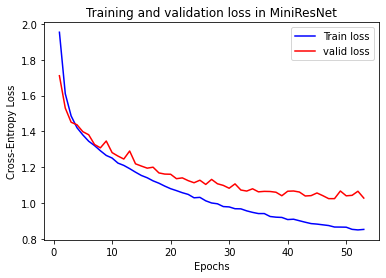

Finished Training.
Accuracy of the network on the 10000 test images: 64.56 %


In [7]:
# Run me
%matplotlib inline
resnet2 = MiniResNet().to(device)
fit(resnet2, max_epochs, device, early_stop=True)